Loading data from kaggle

In [1]:
!pip install --upgrade --force-reinstall  kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.9/164.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.4/163.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.4/128.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 8.9 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha

In [1]:
import os
user = ''
key = ''

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d jocelyndumlao/anerbc-anemia-diagnosis-using-rbc-images

Dataset URL: https://www.kaggle.com/datasets/jocelyndumlao/anerbc-anemia-diagnosis-using-rbc-images
License(s): CC0-1.0
... resuming from 144703488 bytes (7806688304 bytes left) ...
100% 7.38G/7.41G [01:18<00:00, 189MB/s]
100% 7.41G/7.41G [01:18<00:00, 99.3MB/s]


In [2]:
!unzip -q anerbc-anemia-diagnosis-using-rbc-images.zip

In [36]:
!pip install patchify

In [37]:
import os
import shutil
import re
import zipfile
import glob
from patchify import patchify

import matplotlib.pyplot as plt
import cv2
from PIL import Image

import numpy as np
import pickle
import pandas as pd
import random

from tqdm import tqdm

import io
import base64
from IPython.display import HTML

In [40]:
class GlobalConfig:
    def __init__(self):
        self.root_path = '/content/AneRBC dataset a benchmark dataset for computer-aided anemia diagnosis using RBC images. httpsdoi.org10.1093databasebaae120/AneRBC_dataset'
        self.original_image_path = '/content/AneRBC dataset a benchmark dataset for computer-aided anemia diagnosis using RBC images. httpsdoi.org10.1093databasebaae120/AneRBC_dataset/AneRBC-I/Anemic_individuals/Original_images'
        self.original_mask_path = '/content/AneRBC dataset a benchmark dataset for computer-aided anemia diagnosis using RBC images. httpsdoi.org10.1093databasebaae120/AneRBC_dataset/AneRBC-I/Anemic_individuals/Binary_segmented'
        self.patch_size = 256
        self.step = 256

config = GlobalConfig()

In [35]:
# Get sorted list of image and mask file paths
image_files = sorted(glob.glob(os.path.join(config.original_image_path, "*.png")))
mask_files = sorted(glob.glob(os.path.join(config.original_mask_path, "*.png")))

# Define a common size (e.g., first image size)
common_size = Image.open(image_files[0]).size  # (width, height)

# Load, resize, and stack images
large_images = np.stack([
    np.array(Image.open(img).convert("L").resize(common_size, Image.Resampling.LANCZOS))  # Grayscale + Resize
    for img in image_files
])

large_masks = np.stack([
    np.array(Image.open(mask).convert("L").resize(common_size, Image.Resampling.LANCZOS))  # Grayscale + Resize
    for mask in mask_files
])

print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]}")  # (num_images, H, W)
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]}")  # (num_masks, H, W)

Loaded 500 images of shape (960, 1224)
Loaded 500 masks of shape (960, 1224)


In [39]:
large_images.shape[0]

500

In [41]:
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (config.patch_size, config.patch_size), step=config.step)  # Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (config.patch_size, config.patch_size), step=config.step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [42]:
images.shape

(6000, 256, 256)

In [43]:
masks.shape

(6000, 256, 256)

In [44]:
import os
import imageio

# Create directories if they don't exist
os.makedirs('/content/images', exist_ok=True)
os.makedirs('/content/masks', exist_ok=True)

# Save images as PNG
for idx, image in enumerate(images):
    image_filename = f'/content/images/image_{idx}.png'
    imageio.imwrite(image_filename, image)

# Save masks as PNG
for idx, mask in enumerate(masks):
    mask_filename = f'/content/masks/mask_{idx}.png'
    imageio.imwrite(mask_filename, mask * 255)  # Multiply by 255 to bring mask back to range [0, 255]

In [10]:
if os.path.exists(os.path.join(config.root_path, 'AneRBC-II')):
    shutil.rmtree(os.path.join(config.root_path, 'AneRBC-II'))

In [51]:
import pandas as pd

df = pd.DataFrame(
    {"ImageId": sorted(os.listdir('/content/images')),
    "MaskId": sorted(os.listdir('/content/masks'))},)
df = df[:1000]
df

,ImageId,MaskId
0,image_0.png,mask_0.png
1,image_1.png,mask_1.png
2,image_10.png,mask_10.png
3,image_100.png,mask_100.png
4,image_1000.png,mask_1000.png
...,...,...
995,image_1894.png,mask_1894.png
996,image_1895.png,mask_1895.png
997,image_1896.png,mask_1896.png
998,image_1897.png,mask_1897.png


# Fine Tuning

In [12]:
!git clone https://github.com/facebookresearch/segment-anything-2
%cd /content/segment-anything-2
!pip install -q -e .

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 134.70 MiB | 17.79 MiB/s, done.
Resolving deltas: 100% (376/376), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 85.6 kB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


In [13]:
!wget -O sam2_hiera_tiny.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt"
# !wget -O sam2_hiera_small.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt"
# !wget -O sam2_hiera_base_plus.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt"
# !wget -O sam2_hiera_large.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt"

--2025-01-30 22:02:02--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.144.87, 18.154.144.102, 18.154.144.74, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.154.144.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155906050 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_tiny.pt’

sam2_hiera_tiny.pt  100%[===================>] 148.68M   174MB/s    in 0.9s    

2025-01-30 22:02:03 (174 MB/s) - ‘sam2_hiera_tiny.pt’ saved [155906050/155906050]



In [54]:
%cd /content/segment-anything-2

import os
import pandas as pd
import cv2
import torch
import torch.nn.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Path to the chest-ct-segmentation dataset folder
images_dir = '/content/images'
masks_dir = '/content/masks'

# Load the train.csv file
train_df = df.copy()

# Split the data into two halves: one for training and one for testing
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Prepare the training data list
train_data = []
for index, row in train_df.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']

   # Append image and corresponding mask paths
   train_data.append({
       "image": os.path.join(images_dir, image_name),
       "annotation": os.path.join(masks_dir, mask_name)
   })

# Prepare the testing data list (if needed for inference or evaluation later)
test_data = []
for index, row in test_df.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']

   # Append image and corresponding mask paths
   test_data.append({
       "image": os.path.join(images_dir, image_name),
       "annotation": os.path.join(masks_dir, mask_name)
   })


/content/segment-anything-2


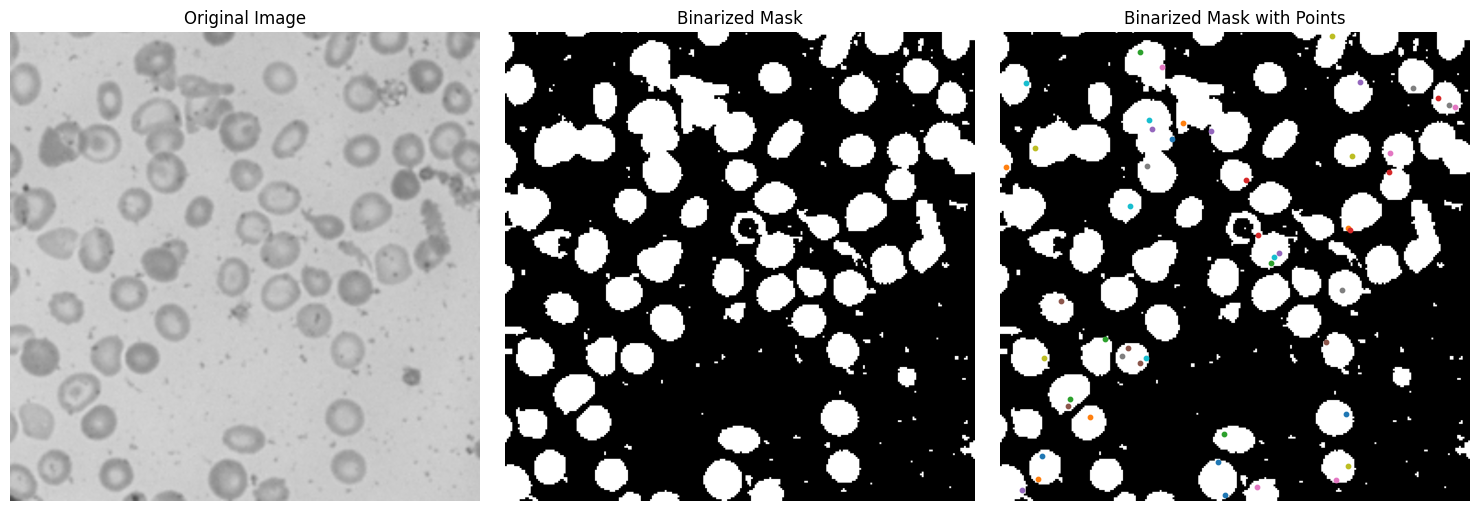

In [59]:
def read_batch(data, visualize_data=False):
   # Select a random entry
   ent = data[np.random.randint(len(data))]

   # Get full paths
   Img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
   ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

   if Img is None or ann_map is None:
       print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
       return None, None, None, 0

   # Resize image and mask
   r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
   Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
   ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

   # Convert to binary mask (0 for background, 1 for masked region)
   binary_mask = np.where(ann_map == 255, 0, 1).astype(np.uint8)

   # Erode the binary mask to avoid boundary points
   eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

   # Get all coordinates inside the eroded mask (where the mask value is 1)
   coords = np.argwhere(eroded_mask > 0)

   # Select random points from the eroded mask
   num_points = 50  # Number of points to select

   # Randomly sample points from `coords` if there are enough points
   if len(coords) > num_points:
        points = coords[np.random.choice(len(coords), num_points, replace=False)]
   else:
        points = coords  # If fewer points exist, use all of them

   # Reformat points to (x, y) from (y, x)
   points = np.array([[p[1], p[0]] for p in points])

   if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=10, label=f'Point {i+1}')  # Corrected to plot y, x order

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

   binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
   binary_mask = binary_mask.transpose((2, 0, 1))
   points = np.expand_dims(points, axis=1)

   # Return the image, binarized mask, points, and number of masks
   return Img, binary_mask, points, num_points

# Visualize the data
Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

In [22]:
sam2_checkpoint = "sam2_hiera_tiny.pt"  # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2_hiera_t.yaml" # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)


In [24]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 3000 # @param

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"

<ipython-input-24-1400bfbef151>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [26]:
torch.cuda.empty_cache()

In [60]:
# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) # 500 , 250, gamma = 0.1
accumulation_steps = 2  # Number of steps to accumulate gradients before updating

for step in range(1, NO_OF_STEPS + 1):
   with torch.cuda.amp.autocast():
       image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)
       if image is None or mask is None or num_masks == 0:
           continue

       input_label = np.ones((num_masks, 1))
       if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
           continue

       if input_point.size == 0 or input_label.size == 0:
           continue

       predictor.set_image(image)
       mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
       if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
           continue

       sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
           points=(unnorm_coords, labels), boxes=None, masks=None,
       )

       batched_mode = unnorm_coords.shape[0] > 1
       high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
       low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
           image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
           image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
           sparse_prompt_embeddings=sparse_embeddings,
           dense_prompt_embeddings=dense_embeddings,
           multimask_output=True,
           repeat_image=batched_mode,
           high_res_features=high_res_features,
       )
       prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

       gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
       prd_mask = torch.sigmoid(prd_masks[:, 0])
       seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

       inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
       iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
       score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
       loss = seg_loss + score_loss * 0.05

       # Apply gradient accumulation
       loss = loss / accumulation_steps
       scaler.scale(loss).backward()

       # Clip gradients
       torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

       if step % accumulation_steps == 0:
           scaler.step(optimizer)
           scaler.update()
           predictor.model.zero_grad()

       # Update scheduler
       scheduler.step()

       if step % 500 == 0:
           FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
           torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

       if step == 1:
           mean_iou = 0

       mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

       if step % 100 == 0:
           print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)


<ipython-input-60-d955846b04ae>:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Step 100:	 Accuracy (IoU) =  0.45654170738985345
Step 200:	 Accuracy (IoU) =  0.712526668460253
Step 300:	 Accuracy (IoU) =  0.8071257472322594
Step 400:	 Accuracy (IoU) =  0.8475872275049531
Step 500:	 Accuracy (IoU) =  0.8663615744530164
Step 600:	 Accuracy (IoU) =  0.8711898096473325
Step 700:	 Accuracy (IoU) =  0.8725546267816648
Step 800:	 Accuracy (IoU) =  0.8798757675274361
Step 900:	 Accuracy (IoU) =  0.8868743029320248
Step 1000:	 Accuracy (IoU) =  0.8867006453090831
Step 1100:	 Accuracy (IoU) =  0.8861076996071477
Step 1200:	 Accuracy (IoU) =  0.8909141179683496
Step 1300:	 Accuracy (IoU) =  0.8868683393788808
Step 1400:	 Accuracy (IoU) =  0.8831686139678397
Step 1500:	 Accuracy (IoU) =  0.8817788560046842
Step 1600:	 Accuracy (IoU) =  0.8793083714734887
Step 1700:	 Accuracy (IoU) =  0.8807264441625988
Step 1800:	 Accuracy (IoU) =  0.8802329898606631
Step 1900:	 Accuracy (IoU) =  0.8837211826888124
Step 2000:	 Accuracy (IoU) =  0.8896004539241544
Step 2100:	 Accuracy (IoU) = 

In [ ]:
import cv2
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import os

# Read and patchify the test image
def read_and_patchify(image_path, mask_path, patch_size, step):
    img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
    mask = cv2.imread(mask_path, 0)  # Read mask as grayscale

    # Resize image to ensure it's divisible by patch_size
    h, w = img.shape[:2]
    new_h = (h // patch_size) * patch_size
    new_w = (w // patch_size) * patch_size
    img = cv2.resize(img, (new_w, new_h))
    mask = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    # Patchify
    img_patches = patchify(img, (patch_size, patch_size, 3), step=step)
    mask_patches = patchify(mask, (patch_size, patch_size), step=step)

    return img_patches, mask_patches, img.shape

# Get sample points inside each patch
def get_points(mask_patch, num_points):
    points = []
    coords = np.argwhere(mask_patch > 0)
    if len(coords) == 0:
        return np.array([])  # Return empty array if no mask present
    for i in range(num_points):
        yx = np.array(coords[np.random.randint(len(coords))])
        points.append([[yx[1], yx[0]]])
    return np.array(points)

# Select a random test sample
selected_entry = random.choice(test_data)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']

# Load and patchify image & mask
patch_size = config.patch_size  # Use same patch size as training
step = config.step  # Use same step size
img_patches, mask_patches, original_shape = read_and_patchify(image_path, mask_path, patch_size, step)

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = "fine_tuned_sam2_1000.torch"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build predictor and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Prepare an empty array to store predicted patches
pred_patches = np.zeros(mask_patches.shape, dtype=np.uint8)

# Iterate over each patch
for i in range(mask_patches.shape[0]):
    for j in range(mask_patches.shape[1]):
        image_patch = img_patches[i, j, 0]  # Extract image patch
        mask_patch = mask_patches[i, j, 0]  # Extract corresponding mask patch

        # Get input points from the mask patch
        num_samples = 10  # Reduce points per patch to avoid noise
        input_points = get_points(mask_patch, num_samples)
        if input_points.shape[0] == 0:
            continue  # Skip if no mask exists in this patch

        # Perform inference
        with torch.no_grad():
            predictor.set_image(image_patch)
            masks, scores, _ = predictor.predict(
                point_coords=input_points,
                point_labels=np.ones([input_points.shape[0], 1])
            )

        # Get best mask based on confidence scores
        best_mask = masks[np.argmax(scores)][0]
        pred_patches[i, j, 0] = best_mask

# Reconstruct the full predicted mask
full_pred_mask = unpatchify(pred_patches, original_shape[:2])

# Visualization: Show original image, ground truth mask, and predicted mask
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(cv2.imread(image_path)[..., ::-1])  # Read again for full image
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Ground Truth Mask')
plt.imshow(cv2.imread(mask_path, 0), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Predicted Mask')
plt.imshow(full_pred_mask, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

In [ ]:
# Randomly select a test image from the test_data
import random

selected_entry = random.choice(test_data)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']

# Load the selected image and mask
image, mask = read_image(image_path, mask_path)

# Generate random points for the input
num_samples = 30  # Number of points per segment to sample
input_points = get_points(mask, num_samples)

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = "fine_tuned_sam2_1000.torch"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

# Visualization: Show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(seg_map, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()